In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras

from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

import medmnist
from medmnist import INFO

import sys
sys.path.insert(0,"../../")

import dataset_without_pytorch

from functions import split_data, get_label_counts, generate_testing_mixup_images, find_boundary_points
from plotting_functions import plot_3_confusion_matricies, plot_calibration, muba_curves
import pandas as pd


In [2]:
data_flag = 'octmnist'

download = True

image_size = 28

info = INFO[data_flag]

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [3]:
# load the data
train_dataset = DataClass(split='train', download=download, size = image_size)
test_dataset = DataClass(split='test', download=download, size = image_size)
val_dataset = DataClass(split='val', download=download, size = image_size)

Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\octmnist.npz


In [4]:
RANDOM_SEED = 1

X_train, y_train, X_val, y_val, X_test_A, y_test_A, X_test_B, y_test_B = split_data(
  train_dataset, test_dataset, val_dataset, RANDOM_SEED = RANDOM_SEED, one_hot_encoded = True, num_classes=4, image_size = 28)


In [5]:
# As a sanity check to make sure we have the correct test data, check counts

get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names = ['choroidal neovascularization', 'diabetic macular edema',  'drusen', 'normal'])


Train
{(0, 0, 0, 1): 46026, (0, 0, 1, 0): 7754, (0, 1, 0, 0): 10213, (1, 0, 0, 0): 33484}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Val
{(0, 0, 0, 1): 5114, (0, 0, 1, 0): 862, (0, 1, 0, 0): 1135, (1, 0, 0, 0): 3721}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Test A
{(0, 0, 0, 1): 69, (0, 0, 1, 0): 72, (0, 1, 0, 0): 80, (1, 0, 0, 0): 79}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

Test B
{(0, 0, 0, 1): 181, (0, 0, 1, 0): 178, (0, 1, 0, 0): 170, (1, 0, 0, 0): 171}  ['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']


In [6]:
test_set_A_df = pd.DataFrame({
    "image_index":[i for i in range(len(y_test_A))],
    "class":[np.argmax(label) for label in y_test_A]}) # 0 if normal, 1 if pneumonia

In [7]:
MUBA_ITERS = 20

muba_df = generate_testing_mixup_images(test_set_A_df, X_test_A, MUBA_ITERS, classes=4)

In [8]:
muba_df.head(-5)

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,image,type,label
0,0.024612,0.975388,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[36.51303146504978], [29.685313698332585], [...",mix,1
1,0.080402,0.919598,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[49.00997173859456], [42.57278335542563], [3...",mix,1
2,0.113945,0.886055,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[56.52376129298308], [50.321378833388806], [...",mix,1
3,0.155570,0.844430,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[65.84766064446893], [59.936650039608594], [...",mix,1
4,0.219966,0.780034,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[80.27245673825524], [74.8122210113257], [71...",mix,1
...,...,...,...,...,...,...,...,...,...,...,...
674130,0.000000,0.000000,0.500681,0.499319,NaN,NaN,281.0,299.0,"[[[20.00136137057582], [21.50068068528791], [2...",mix,2
674131,0.000000,0.000000,0.562927,0.437073,NaN,NaN,281.0,299.0,"[[[20.12585396269374], [21.56292698134687], [2...",mix,2
674132,0.000000,0.000000,0.625502,0.374498,NaN,NaN,281.0,299.0,"[[[20.251004538396735], [21.625502269198368], ...",mix,2
674133,0.000000,0.000000,0.683810,0.316190,NaN,NaN,281.0,299.0,"[[[20.367620862685705], [21.683810431342852], ...",mix,2


In [9]:
model = keras.models.load_model("best_model_epoch_10.h5")
activations_model = keras.Model(model.input,model.layers[-2].output)

In [10]:
predictions_A = model.predict(X_test_A)
activations_A = activations_model.predict(X_test_A)

predictions_B = model.predict(X_test_B)
activations_B = activations_model.predict(X_test_B)

print("Stacking - this can take some time.")
stacked_images = np.stack(muba_df["image"])
predictions_mixup = model.predict(stacked_images)
activations_mixup = activations_model.predict(stacked_images)

22/22 [==============================] - 0s 10ms/step
Stacking - this can take some time.
21067/21067 [==============================] - 211s 10ms/step


In [11]:
muba_df["predictions_0"] = [p[0] for p in predictions_mixup]
muba_df["predictions_1"] = [p[1] for p in predictions_mixup]
muba_df["predictions_2"] = [p[2] for p in predictions_mixup]
muba_df["predictions_3"] = [p[3] for p in predictions_mixup]
muba_df["argmax_pred"] = [np.argmax(p) for p in predictions_mixup]
muba_df["activations"] = [a for a in activations_mixup]

In [12]:
muba_df.head(-5)

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,image,type,label,predictions_0,predictions_1,predictions_2,predictions_3,argmax_pred,activations
0,0.024612,0.975388,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[36.51303146504978], [29.685313698332585], [...",mix,1,0.000015,0.999963,0.000002,0.000019,1,"[0.48519385, 0.0, 0.0, 0.0, 0.0, 0.10945509, 0..."
1,0.080402,0.919598,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[49.00997173859456], [42.57278335542563], [3...",mix,1,0.000124,0.999781,0.000020,0.000074,1,"[0.41744995, 0.0, 0.0, 0.0, 0.0, 0.041285474, ..."
2,0.113945,0.886055,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[56.52376129298308], [50.321378833388806], [...",mix,1,0.000328,0.999485,0.000053,0.000135,1,"[0.37997955, 0.0, 0.0, 0.0, 0.0, 0.012465435, ..."
3,0.155570,0.844430,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[65.84766064446893], [59.936650039608594], [...",mix,1,0.000964,0.998662,0.000121,0.000252,1,"[0.338879, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.219966,0.780034,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[80.27245673825524], [74.8122210113257], [71...",mix,1,0.009095,0.989760,0.000427,0.000719,1,"[0.2356932, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674130,0.000000,0.000000,0.500681,0.499319,NaN,NaN,281.0,299.0,"[[[20.00136137057582], [21.50068068528791], [2...",mix,2,0.959602,0.002496,0.007830,0.030072,0,"[0.0, 0.0, 0.0, 0.49989805, 0.0, 0.0, 0.0, 0.0..."
674131,0.000000,0.000000,0.562927,0.437073,NaN,NaN,281.0,299.0,"[[[20.12585396269374], [21.56292698134687], [2...",mix,2,0.990564,0.000562,0.003286,0.005588,0,"[0.0, 0.0, 0.0, 0.48053163, 0.0, 0.0, 0.0, 0.0..."
674132,0.000000,0.000000,0.625502,0.374498,NaN,NaN,281.0,299.0,"[[[20.251004538396735], [21.625502269198368], ...",mix,2,0.994202,0.000285,0.002955,0.002559,0,"[0.0, 0.0, 0.0, 0.47462285, 0.0, 0.0, 0.0, 0.0..."
674133,0.000000,0.000000,0.683810,0.316190,NaN,NaN,281.0,299.0,"[[[20.367620862685705], [21.683810431342852], ...",mix,2,0.993745,0.000293,0.004137,0.001825,0,"[0.0, 0.0, 0.0, 0.46303272, 0.0, 0.0, 0.0, 0.0..."


(array([174590.,      0.,      0., 176000.,      0.,      0., 164160.,
             0.,      0., 159390.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

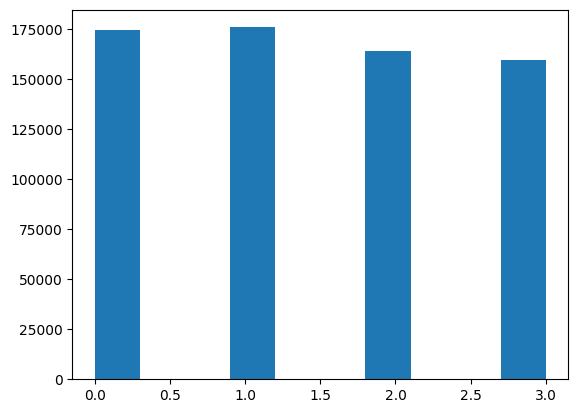

In [13]:
plt.hist(muba_df["label"])

In [14]:
# Check this works
boundary_points_df = find_boundary_points(muba_df, X_test_A, MUBA_ITERS, classes = 4)

In [15]:
boundary_points_df.head(-5)

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,image,type,label
0,0.301860,0.698140,0.000000,0.000000,1.0,0.0,NaN,NaN,"[[[98.61658469686722], [93.72960296864433], [9...",boundary,1
1,0.141534,0.858466,0.000000,0.000000,1.0,2.0,NaN,NaN,"[[[76.43915180054044], [72.14682371882267], [6...",boundary,1
2,0.348900,0.000000,0.651100,0.000000,1.0,NaN,4.0,NaN,"[[[122.17553773212026], [122.82663803735497], ...",boundary,2
3,0.308188,0.691812,0.000000,0.000000,1.0,5.0,NaN,NaN,"[[[255.0], [255.0], [255.0], [254.0], [253.691...",boundary,1
4,0.330846,0.000000,0.000000,0.669154,1.0,NaN,NaN,6.0,"[[[99.75618736172804], [99.08703299690791], [9...",boundary,3
...,...,...,...,...,...,...,...,...,...,...,...
44064,0.000000,0.000000,0.227040,0.772960,NaN,NaN,281.0,269.0,"[[[31.04847597350247], [30.50255659296363], [3...",boundary,3
44065,0.000000,0.000000,0.246445,0.753555,NaN,NaN,281.0,276.0,"[[[120.4692719399287], [122.22282703038272], [...",boundary,3
44066,0.000000,0.000000,0.199530,0.800470,NaN,NaN,281.0,286.0,"[[[22.600940933055455], [22.800470466527727], ...",boundary,3
44067,0.000000,0.000000,0.118591,0.881409,NaN,NaN,281.0,292.0,"[[[36.86535616284023], [37.86535616284023], [3...",boundary,3


In [16]:
predictions_boundary = model.predict(np.stack(boundary_points_df["image"]))
activations_boundary = activations_model.predict(np.stack(boundary_points_df["image"]))

1378/1378 [==============================] - 13s 10ms/step


In [17]:
test_set_A_df = pd.DataFrame({
    "alpha_class_0" : [label[0] for label in y_test_A],
    "alpha_class_1" : [label[1] for label in y_test_A],
    "alpha_class_2" : [label[2] for label in y_test_A],
    "alpha_class_3" : [label[3] for label in y_test_A],
    "class_0_index" : None,
    "class_1_index" : None,
    "class_2_index" : None,
    "class_3_index" : None,
    "image" : [image for image in X_test_A],
    "type" : "A",
    "label" : [np.argmax(l) for l in y_test_A],
    "predictions_0" : [p[0] for p in predictions_A],
    "predictions_1" : [p[1] for p in predictions_A],
    "predictions_2" : [p[2] for p in predictions_A],
    "predictions_3" : [p[3] for p in predictions_A],
    "argmax_pred" : [np.argmax(p) for p in predictions_A],
    "activations" : [a for a in activations_A]
})
test_set_B_df = pd.DataFrame({
    "alpha_class_0" : [label[0] for label in y_test_B],
    "alpha_class_1" : [label[1] for label in y_test_B],
    "alpha_class_2" : [label[2] for label in y_test_B],
    "alpha_class_3" : [label[3] for label in y_test_B],
    "class_0_index" : None,
    "class_1_index" : None,
    "class_2_index" : None,
    "class_3_index" : None,
    "image" : [image for image in X_test_B],
    "type" : "B",
    "label" : [np.argmax(l) for l in y_test_B],
    "predictions_0" : [p[0] for p in predictions_B],
    "predictions_1" : [p[1] for p in predictions_B],
    "predictions_2" : [p[2] for p in predictions_B],
    "predictions_3" : [p[3] for p in predictions_B],
    "argmax_pred" : [np.argmax(p) for p in predictions_B],
    "activations" : [a for a in activations_B]
})

boundary_points_df["predictions_0"] = [p[0] for p in predictions_boundary]
boundary_points_df["predictions_1"] = [p[1] for p in predictions_boundary]
boundary_points_df["predictions_2"] = [p[0] for p in predictions_boundary]
boundary_points_df["predictions_3"] = [p[1] for p in predictions_boundary]
boundary_points_df["argmax_pred"] = [np.argmax(p) for p in predictions_boundary]
boundary_points_df["activations"] = [a for a in activations_boundary]

In [18]:
df = pd.concat([test_set_A_df, test_set_B_df, muba_df, boundary_points_df],axis=0, ignore_index=True)

In [19]:
muba_projections = TSNE(2,random_state=1, verbose = 2).fit_transform(np.stack(df["activations"]))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 719214 samples in 0.051s...
[t-SNE] Computed neighbors for 719214 samples in 2073.835s...
[t-SNE] Computed conditional probabilities for sample 1000 / 719214
[t-SNE] Computed conditional probabilities for sample 2000 / 719214
[t-SNE] Computed conditional probabilities for sample 3000 / 719214
[t-SNE] Computed conditional probabilities for sample 4000 / 719214
[t-SNE] Computed conditional probabilities for sample 5000 / 719214
[t-SNE] Computed conditional probabilities for sample 6000 / 719214
[t-SNE] Computed conditional probabilities for sample 7000 / 719214
[t-SNE] Computed conditional probabilities for sample 8000 / 719214
[t-SNE] Computed conditional probabilities for sample 9000 / 719214
[t-SNE] Computed conditional probabilities for sample 10000 / 719214
[t-SNE] Computed conditional probabilities for sample 11000 / 719214
[t-SNE] Computed conditional probabilities for sample 12000 / 719214
[t-SNE] Computed conditional prob

In [20]:
df["projection_x"] = [x[0] for x in muba_projections]
df["projection_y"] = [x[1] for x in muba_projections]

In [21]:
df_to_save = df.drop(columns=["image"])
df_to_save.to_pickle("muba_df.csv")

In [2]:
df = pd.read_pickle("muba_df.csv")

In [3]:
true_images_A_df = df[df["type"] == "A"]
true_images_B_df = df[df["type"] == "B"]

mixup_images_df =  df[df["type"] == "mix"]
boundary_images_df = df[df["type"] == "boundary"]

true_A_class_0 = true_images_A_df[true_images_A_df["label"] == 0]
true_A_class_1 = true_images_A_df[true_images_A_df["label"] == 1]
true_A_class_2 = true_images_A_df[true_images_A_df["label"] == 2]
true_A_class_3 = true_images_A_df[true_images_A_df["label"] == 3]

true_B_class_0 = true_images_B_df[true_images_B_df["label"] == 0]
true_B_class_1 = true_images_B_df[true_images_B_df["label"] == 1]
true_B_class_2 = true_images_B_df[true_images_B_df["label"] == 2]
true_B_class_3 = true_images_B_df[true_images_B_df["label"] == 3]

mixup_0 = mixup_images_df[mixup_images_df["label"] == 0]
mixup_1 = mixup_images_df[mixup_images_df["label"] == 1]
mixup_2 = mixup_images_df[mixup_images_df["label"] == 2]
mixup_3 = mixup_images_df[mixup_images_df["label"] == 3]

true_A_errors = true_images_A_df[true_images_A_df["label"] != true_images_A_df["argmax_pred"]]
true_B_errors = true_images_B_df[true_images_B_df["label"] != true_images_B_df["argmax_pred"]]
mixup_errors = mixup_images_df[mixup_images_df["label"] != mixup_images_df["argmax_pred"]]

error_free_true_A_class_0 = true_A_class_0[true_A_class_0["label"] == true_A_class_0["argmax_pred"]]
error_free_true_A_class_1 = true_A_class_1[true_A_class_1["label"] == true_A_class_1["argmax_pred"]]
error_free_true_A_class_2 = true_A_class_2[true_A_class_2["label"] == true_A_class_2["argmax_pred"]]
error_free_true_A_class_3 = true_A_class_3[true_A_class_3["label"] == true_A_class_3["argmax_pred"]]

error_free_mixup_class_0 = mixup_0[mixup_0["label"] == mixup_0["argmax_pred"]]
error_free_mixup_class_1 = mixup_1[mixup_1["label"] == mixup_1["argmax_pred"]]
error_free_mixup_class_2 = mixup_2[mixup_2["label"] == mixup_2["argmax_pred"]]
error_free_mixup_class_3 = mixup_3[mixup_3["label"] == mixup_3["argmax_pred"]]

In [4]:
true_images_B_df

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,type,label,predictions_0,predictions_1,predictions_2,predictions_3,argmax_pred,activations,projection_x,projection_y
300,1.0,0.0,0.0,0.0,None,None,None,None,B,0,0.926437,0.058968,0.010246,0.004349,0,"[0.0, 0.0, 0.0, 0.120777644, 0.0, 0.0, 0.0, 0....",-61.121647,6.794946
301,0.0,0.0,1.0,0.0,None,None,None,None,B,2,0.887709,0.044478,0.036177,0.031636,0,"[0.0, 0.0, 0.0, 0.28860423, 0.0, 0.0, 0.0, 0.0...",-7.539534,19.825972
302,0.0,0.0,0.0,1.0,None,None,None,None,B,3,0.000147,0.001731,0.016488,0.981635,3,"[1.4598058, 0.0, 0.0, 0.23412712, 0.0, 0.0, 0....",104.116875,64.713776
303,0.0,1.0,0.0,0.0,None,None,None,None,B,1,0.990869,0.008665,0.000152,0.000315,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-93.986977,50.720570
304,0.0,0.0,0.0,1.0,None,None,None,None,B,3,0.105368,0.011105,0.608697,0.274829,2,"[0.4732862, 0.0, 0.0, 0.3501261, 0.0, 0.0, 0.0...",18.639076,-63.175644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,1.0,None,None,None,None,B,3,0.797193,0.020867,0.030856,0.151084,0,"[0.0, 0.0, 0.0, 0.43814287, 0.0, 0.0, 0.0, 0.0...",36.423706,31.495665
996,0.0,0.0,1.0,0.0,None,None,None,None,B,2,0.686024,0.014918,0.272810,0.026248,0,"[0.0, 0.0, 0.0, 0.40171343, 0.0, 0.0, 0.346667...",-13.447964,-25.097448
997,0.0,0.0,1.0,0.0,None,None,None,None,B,2,0.692461,0.059051,0.241922,0.006567,0,"[0.0, 0.0, 0.0, 0.18254437, 0.0, 0.0, 0.332448...",-105.096207,-34.161224
998,1.0,0.0,0.0,0.0,None,None,None,None,B,0,0.998378,0.001099,0.000219,0.000303,0,"[0.0, 0.0, 0.0, 0.14396285, 0.0, 0.0, 0.0, 0.0...",-21.058058,92.012375


In [5]:
mixup_errors_0_1 = mixup_errors[(mixup_errors["alpha_class_0"] > 0) & (mixup_errors["alpha_class_1"] > 0)]
mixup_errors_0_2 = mixup_errors[(mixup_errors["alpha_class_0"] > 0) & (mixup_errors["alpha_class_2"] > 0)]
mixup_errors_0_3 = mixup_errors[(mixup_errors["alpha_class_0"] > 0) & (mixup_errors["alpha_class_3"] > 0)]
mixup_errors_1_2 = mixup_errors[(mixup_errors["alpha_class_1"] > 0) & (mixup_errors["alpha_class_2"] > 0)]
mixup_errors_1_3 = mixup_errors[(mixup_errors["alpha_class_1"] > 0) & (mixup_errors["alpha_class_3"] > 0)]
mixup_errors_2_3 = mixup_errors[(mixup_errors["alpha_class_2"] > 0) & (mixup_errors["alpha_class_3"] > 0)]

boundaries_0_1 = boundary_images_df[(boundary_images_df["alpha_class_0"] > 0) & (boundary_images_df["alpha_class_1"] > 0)]
boundaries_0_2 = boundary_images_df[(boundary_images_df["alpha_class_0"] > 0) & (boundary_images_df["alpha_class_2"] > 0)]
boundaries_0_3 = boundary_images_df[(boundary_images_df["alpha_class_0"] > 0) & (boundary_images_df["alpha_class_3"] > 0)]
boundaries_1_2 = boundary_images_df[(boundary_images_df["alpha_class_1"] > 0) & (boundary_images_df["alpha_class_2"] > 0)]
boundaries_1_3 = boundary_images_df[(boundary_images_df["alpha_class_1"] > 0) & (boundary_images_df["alpha_class_3"] > 0)]
boundaries_2_3 = boundary_images_df[(boundary_images_df["alpha_class_2"] > 0) & (boundary_images_df["alpha_class_3"] > 0)]

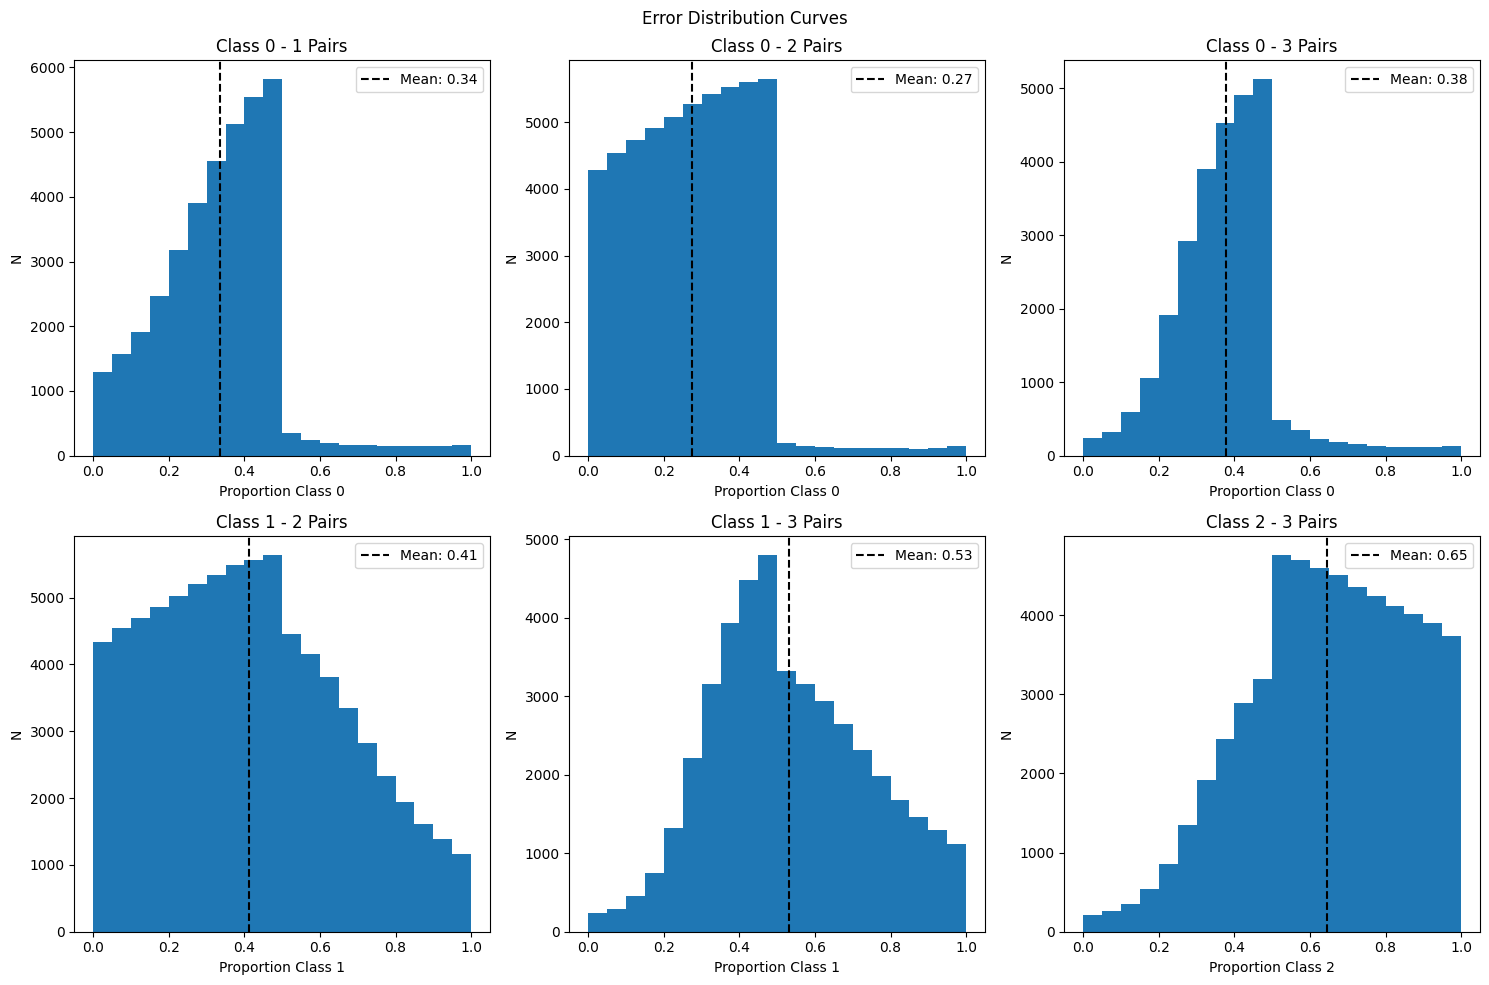

In [6]:
fig, axs = plt.subplots(2,3,figsize=(15,10))

#x_labels = ['Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Diabetic Macular Edema', 'Proportion Diabetic Macular Edema', 'Proportion Drusen']
x_labels=["Proportion Class 0", "Proportion Class 0", "Proportion Class 0", "Proportion Class 1", "Proportion Class 1", "Proportion Class 2"]
alpha_keys = ["alpha_class_0","alpha_class_0","alpha_class_0","alpha_class_1","alpha_class_1","alpha_class_2"]
titles = ["Class 0 - 1 Pairs","Class 0 - 2 Pairs","Class 0 - 3 Pairs","Class 1 - 2 Pairs","Class 1 - 3 Pairs","Class 2 - 3 Pairs",]
errors = [mixup_errors_0_1,mixup_errors_0_2,mixup_errors_0_3,mixup_errors_1_2,mixup_errors_1_3,mixup_errors_2_3]

for ax, x, e, key, t in zip(axs.flat, x_labels, errors, alpha_keys, titles):
    ax.hist(e[key], bins = [i/20 for i in range(21)])
    ax.set_xlabel(x)
    ax.set_ylabel("N")
    ax.set_title(t)
    ax.axvline(np.mean(e[key]),linestyle = "--", color = "black",label=f"Mean: {round(np.mean(e[key]),2)}")
    ax.legend()

plt.suptitle("Error Distribution Curves")
fig.tight_layout()

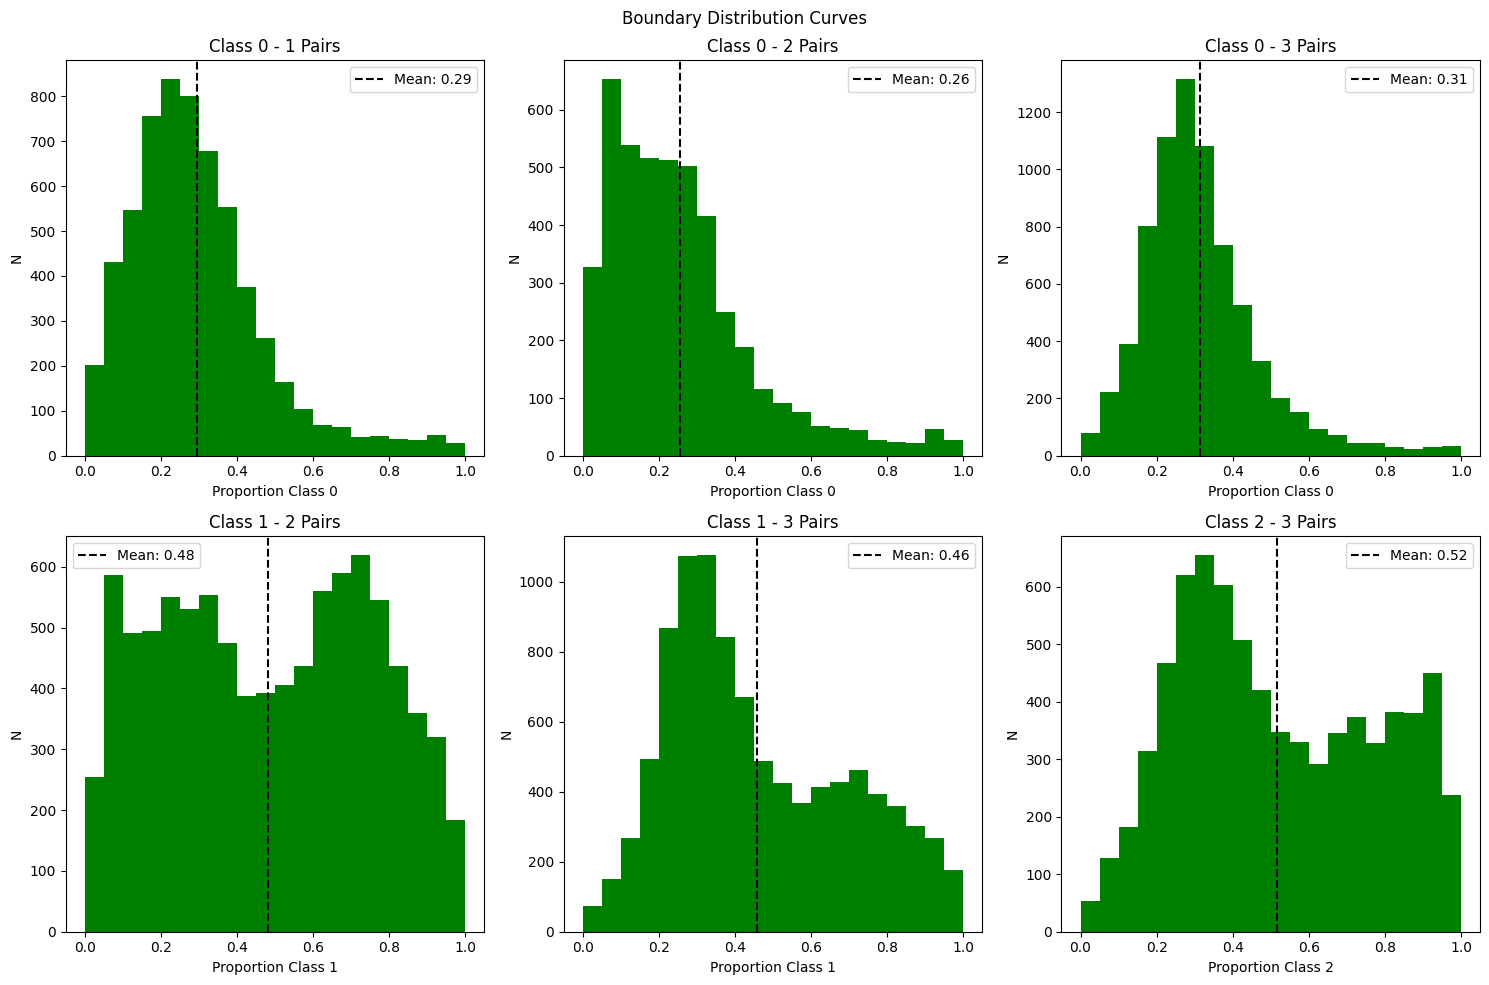

In [7]:
fig, axs = plt.subplots(2,3,figsize=(15,10))

#x_labels = ['Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Choroidal Neovascularization', 'Proportion Diabetic Macular Edema', 'Proportion Diabetic Macular Edema', 'Proportion Drusen']
x_labels=["Proportion Class 0", "Proportion Class 0", "Proportion Class 0", "Proportion Class 1", "Proportion Class 1", "Proportion Class 2"]
alpha_keys = ["alpha_class_0","alpha_class_0","alpha_class_0","alpha_class_1","alpha_class_1","alpha_class_2"]
titles = ["Class 0 - 1 Pairs","Class 0 - 2 Pairs","Class 0 - 3 Pairs","Class 1 - 2 Pairs","Class 1 - 3 Pairs","Class 2 - 3 Pairs",]
errors = [boundaries_0_1,boundaries_0_2,boundaries_0_3,boundaries_1_2,boundaries_1_3,boundaries_2_3]

for ax, x, e, key, t in zip(axs.flat, x_labels, errors, alpha_keys, titles):
    ax.hist(e[key], bins = [i/20 for i in range(21)], color="green")
    ax.set_xlabel(x)
    ax.set_ylabel("N")
    ax.set_title(t)
    ax.axvline(np.mean(e[key]),linestyle = "--", color = "black",label=f"Mean: {round(np.mean(e[key]),2)}")
    ax.legend()

plt.suptitle("Boundary Distribution Curves")
fig.tight_layout()

In [8]:
print(classification_report(mixup_images_df["label"],mixup_images_df["argmax_pred"]))

              precision    recall  f1-score   support

           0       0.43      0.97      0.59    174590
           1       0.78      0.52      0.62    176000
           2       0.82      0.12      0.21    164160
           3       0.72      0.62      0.67    159390

    accuracy                           0.56    674140
   macro avg       0.69      0.56      0.52    674140
weighted avg       0.68      0.56      0.52    674140



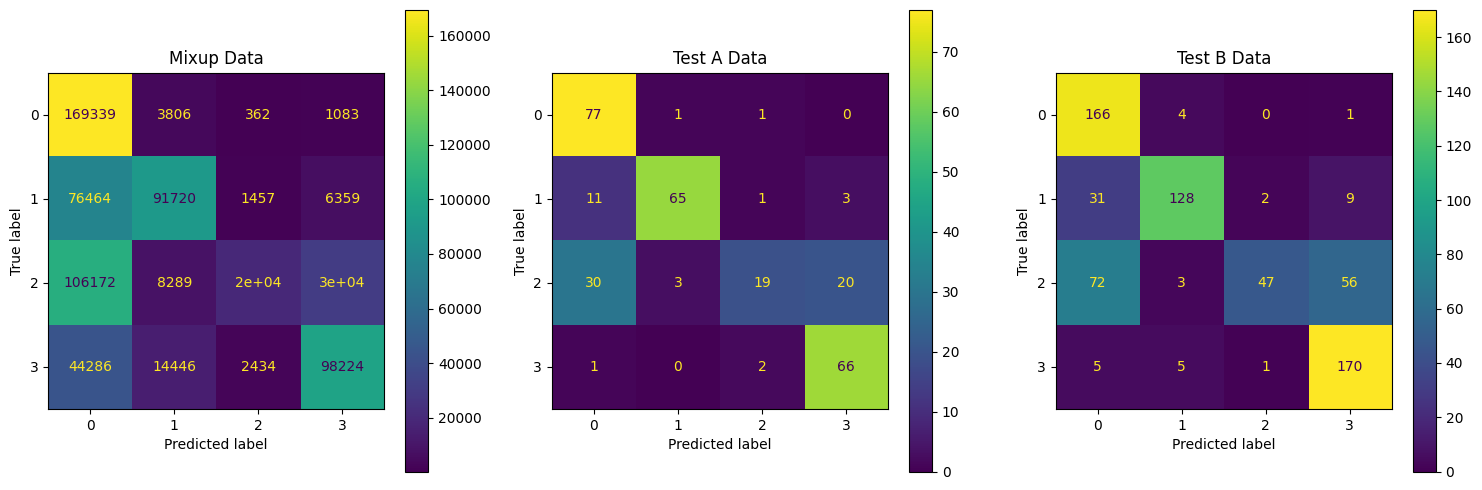

In [9]:
plot_3_confusion_matricies(mixup_images_df,true_images_A_df,true_images_B_df, labels = [0,1,2,3])

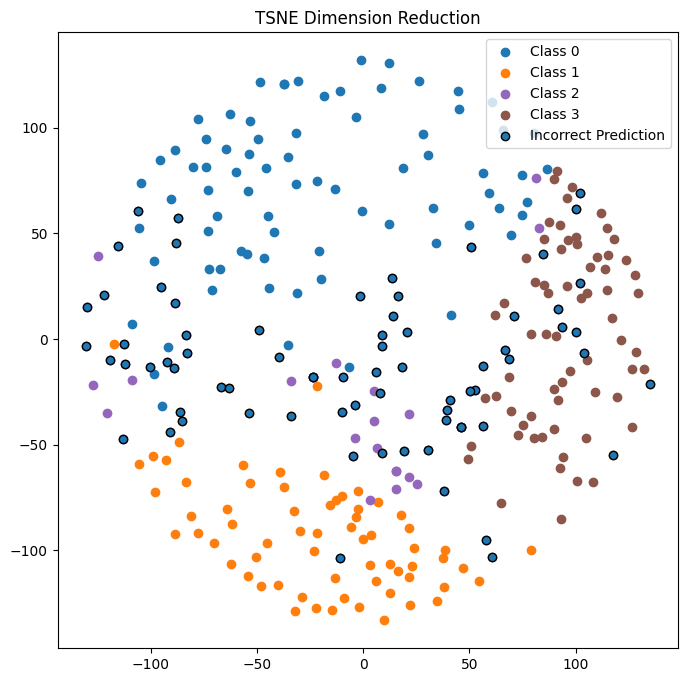

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")
ax.scatter(true_A_class_2["projection_x"], true_A_class_2["projection_y"], color = "C4", label = "Class 2")
ax.scatter(true_A_class_3["projection_x"], true_A_class_3["projection_y"], color = "C5", label = "Class 3")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


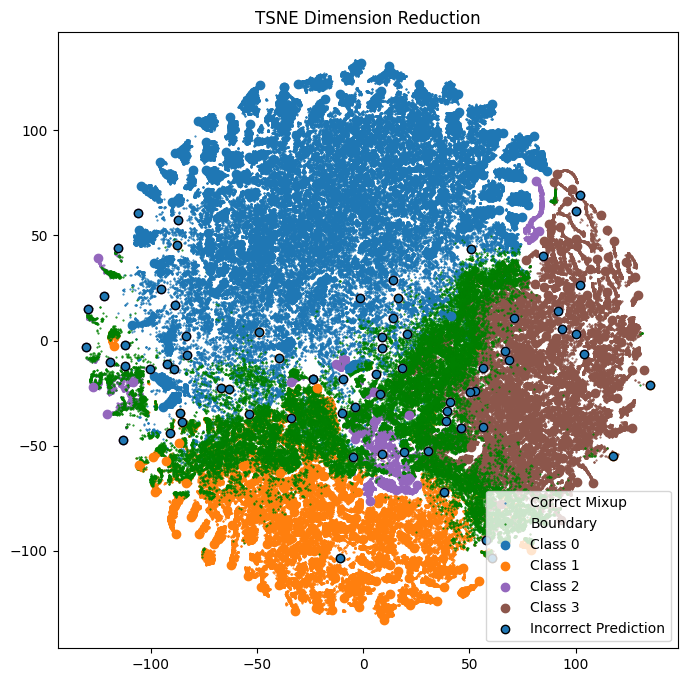

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(error_free_mixup_class_0["projection_x"],error_free_mixup_class_0["projection_y"], color = "C0", marker = ".", s = 1, label = "Correct Mixup")
ax.scatter(error_free_mixup_class_1["projection_x"],error_free_mixup_class_1["projection_y"], color = "C1", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_2["projection_x"],error_free_mixup_class_2["projection_y"], color = "C4", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_3["projection_x"],error_free_mixup_class_3["projection_y"], color = "C5", marker = ".", s = 1)
ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"], color = "green", marker = ".", s = 1, label = "Boundary")

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")
ax.scatter(true_A_class_2["projection_x"], true_A_class_2["projection_y"], color = "C4", label = "Class 2")
ax.scatter(true_A_class_3["projection_x"], true_A_class_3["projection_y"], color = "C5", label = "Class 3")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

In [12]:
multiple_boundaries_mask = boundary_images_df.duplicated(subset=["class_0_index","class_1_index"], keep=False)
multiple_boundaries = boundary_images_df[multiple_boundaries_mask]

In [13]:
multiple_boundaries

,alpha_class_0,alpha_class_1,alpha_class_2,alpha_class_3,class_0_index,class_1_index,class_2_index,class_3_index,type,label,predictions_0,predictions_1,predictions_2,predictions_3,argmax_pred,activations,projection_x,projection_y
675142,0.348900,0.0,0.651100,0.000000,1.0,NaN,4.0,NaN,boundary,2,0.413501,0.005287,0.413501,0.005287,3,"[0.04324746, 0.0, 0.0, 0.6886924, 0.0, 0.0, 0....",50.328365,32.494987
675144,0.330846,0.0,0.000000,0.669154,1.0,NaN,NaN,6.0,boundary,3,0.492197,0.016513,0.492197,0.016513,0,"[0.0, 0.0, 0.0, 0.53780216, 0.0, 0.0, 0.0, 0.0...",48.297871,29.365410
675146,0.199006,0.0,0.800994,0.000000,1.0,NaN,8.0,NaN,boundary,2,0.400484,0.000074,0.400484,0.000074,2,"[0.18944542, 0.0, 0.0, 0.344183, 0.0, 0.0, 0.5...",-124.269478,-20.244051
675148,0.153261,0.0,0.000000,0.846739,1.0,NaN,NaN,10.0,boundary,3,0.151358,0.134786,0.151358,0.134786,3,"[0.30462074, 0.0, 0.0, 0.31578812, 0.0, 0.0, 0...",32.135071,-47.898090
675149,0.187957,0.0,0.000000,0.812043,1.0,NaN,NaN,10.0,boundary,3,0.407808,0.110110,0.407808,0.110110,0,"[0.1363091, 0.0, 0.0, 0.2959679, 0.0, 0.0, 0.1...",16.425461,-39.562614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719209,0.000000,0.0,0.234634,0.765366,NaN,NaN,281.0,293.0,boundary,3,0.544670,0.285287,0.544670,0.285287,0,"[0.0017651767, 0.0, 0.0, 0.22320464, 0.0, 0.0,...",-20.639692,-40.443558
719210,0.000000,0.0,0.246620,0.753380,NaN,NaN,281.0,296.0,boundary,3,0.390633,0.054404,0.390633,0.054404,3,"[0.03687705, 0.0, 0.0, 0.44664142, 0.0, 0.0, 0...",51.936199,12.535751
719211,0.000000,0.0,0.241113,0.758887,NaN,NaN,281.0,297.0,boundary,3,0.216918,0.337091,0.216918,0.337091,1,"[0.16044666, 0.0, 0.0, 0.24309033, 0.0, 0.0, 0...",31.575804,-33.971066
719212,0.000000,0.0,0.284983,0.715017,NaN,NaN,281.0,297.0,boundary,3,0.275504,0.301734,0.275504,0.301734,1,"[0.11769326, 0.0, 0.0, 0.25945026, 0.0, 0.0, 0...",31.395086,-33.599720


In [14]:
POINT_0 = 1
POINT_1 = 278

POINT_0_df = true_A_class_0.loc[[POINT_0]]
POINT_1_df = true_A_class_1.loc[[POINT_1]]

point_1_df = mixup_images_df[mixup_images_df["class_0_index"]==POINT_0]
path_df = point_1_df[point_1_df["class_1_index"]==POINT_1]

boundary_points_1 = boundary_images_df[boundary_images_df["class_0_index"]==POINT_0]
boundary_point = boundary_points_1[boundary_points_1["class_1_index"]==POINT_1]

if len(POINT_0_df) == 0:
    print(f"Point {POINT_0} is not in this class")
if len(POINT_1_df) == 0:
    print(f"Point {POINT_1} is not in this class")

path_df = pd.concat([POINT_0_df, POINT_1_df, boundary_point, path_df],axis=0,ignore_index=False).sort_values("alpha_class_0")


C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Will Poulett\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


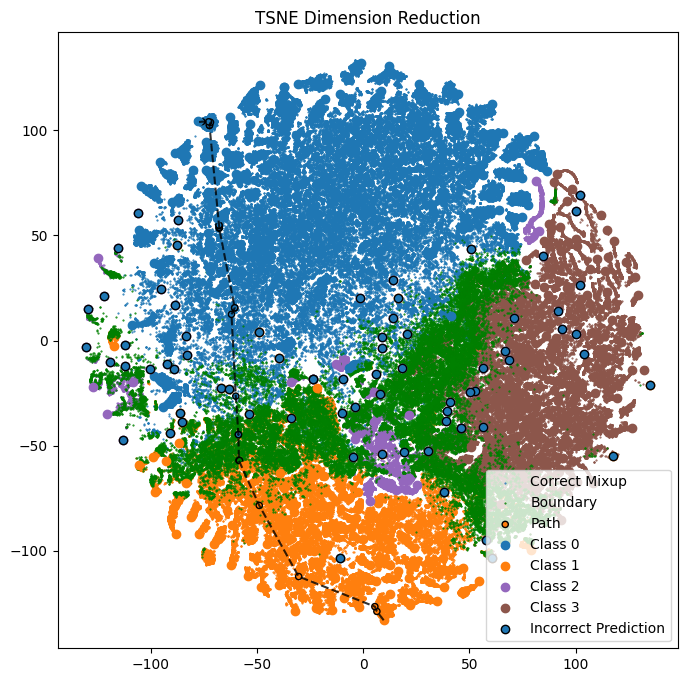

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(error_free_mixup_class_0["projection_x"],error_free_mixup_class_0["projection_y"], color = "C0", marker = ".", s = 1, label = "Correct Mixup")
ax.scatter(error_free_mixup_class_1["projection_x"],error_free_mixup_class_1["projection_y"], color = "C1", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_2["projection_x"],error_free_mixup_class_2["projection_y"], color = "C4", marker = ".", s = 1)
ax.scatter(error_free_mixup_class_3["projection_x"],error_free_mixup_class_3["projection_y"], color = "C5", marker = ".", s = 1)
ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"], color = "green", marker = ".", s = 1, label = "Boundary")
ax.plot(path_df["projection_x"],path_df["projection_y"],alpha=0.8,linestyle="--",color="black")

ax.scatter(path_df["projection_x"],path_df["projection_y"],marker="o",s=20,c=["C0" if l == 0 else "C1" for l in path_df["argmax_pred"]], edgecolors = "black",label="Path")
ax.scatter(boundary_point["projection_x"],boundary_point["projection_y"],marker="o",s=20,c="green", edgecolors = "black")

ax.scatter(true_A_class_0["projection_x"], true_A_class_0["projection_y"], color = "C0", label = "Class 0")
ax.scatter(true_A_class_1["projection_x"], true_A_class_1["projection_y"], color = "C1", label = "Class 1")
ax.scatter(true_A_class_2["projection_x"], true_A_class_2["projection_y"], color = "C4", label = "Class 2")
ax.scatter(true_A_class_3["projection_x"], true_A_class_3["projection_y"], color = "C5", label = "Class 3")

ax.scatter(true_A_errors["projection_x"], true_A_errors["projection_y"], color = None, edgecolors = "black", label = "Incorrect Prediction")

ax.set_title("TSNE Dimension Reduction")
ax.legend()

In [18]:
from scipy import spatial
from collections import Counter

# This may be a function that we want to change for different models, so we define it within the notebook.
def get_distances():

    all_images_without_B_df = df[df["type"] != "B"].reset_index()
    activations_A = [a for a in true_images_A_df["activations"]]
    activations_B = [a for a in true_images_B_df["activations"]]
    activations_mixup = [a for a in mixup_images_df["activations"]]
    activations_boundary = [a for a in boundary_images_df["activations"]]
    all = [a for a in all_images_without_B_df["activations"]]

    tree_true_A = spatial.KDTree(activations_A)
    tree_true_B = spatial.KDTree(activations_B)
    tree_mixup  = spatial.KDTree(activations_mixup)
    tree_boundaries = spatial.KDTree(activations_boundary)
    tree_all = spatial.KDTree(all)

    distances_to_all = []
    distances_B_to_boundary = []
    distances_B_to_mixup = []
    B_class_0_to_boundary = []
    B_class_1_to_boundary = []
    B_class_2_to_boundary = []
    B_class_3_to_boundary = []
    B_class_0_incorrect_to_boundary = []
    B_class_1_incorrect_to_boundary = []
    B_class_2_incorrect_to_boundary = []
    B_class_3_incorrect_to_boundary = []
    B_class_0_correct_to_boundary = []
    B_class_1_correct_to_boundary = []
    B_class_2_correct_to_boundary = []
    B_class_3_correct_to_boundary = []
    types = []
    distance_B_to_B = []
    
    distances_A_to_boundary = []
    A_class_0_to_boundary = []
    A_class_1_to_boundary = []
    A_class_2_to_boundary = []
    A_class_3_to_boundary = []
    A_class_0_incorrect_to_boundary = []
    A_class_1_incorrect_to_boundary = []
    A_class_2_incorrect_to_boundary = []
    A_class_3_incorrect_to_boundary = []
    distance_A_to_A = []

    for vector, label, pred in zip(activations_B,true_images_B_df["label"],true_images_B_df["argmax_pred"]):

        distance, id = tree_all.query(vector)
        types.append(all_images_without_B_df.loc[[id]]["type"][id])
        distances_to_all.append(distance)

        boundary_dist = tree_boundaries.query(vector)[0]

        distance_B_to_B.append(tree_true_B.query(vector,2)[0][1])
        distances_B_to_boundary.append(boundary_dist)
        distances_B_to_mixup.append(tree_mixup.query(vector)[0])

        if label == 0:
            B_class_0_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_0_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_0_correct_to_boundary.append(boundary_dist)
        elif label == 1:
            B_class_1_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_1_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_1_correct_to_boundary.append(boundary_dist)
        elif label == 2:
            B_class_2_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_2_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_2_correct_to_boundary.append(boundary_dist)
        elif label == 3:
            B_class_3_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                B_class_3_incorrect_to_boundary.append(boundary_dist)
            else:
                B_class_3_correct_to_boundary.append(boundary_dist)

    for vector, label, pred in zip(activations_A, true_images_A_df["label"],true_images_A_df["argmax_pred"]):

        boundary_dist = tree_boundaries.query(vector)[0]

        distance_A_to_A.append(tree_true_A.query(vector,2)[0][1])
        distances_A_to_boundary.append(boundary_dist)

        if label == 0:
            A_class_0_to_boundary.append(boundary_dist)
            if pred != label: #Incorrect
                A_class_0_incorrect_to_boundary.append(boundary_dist)
        elif label == 1:
            A_class_1_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                A_class_1_incorrect_to_boundary.append(boundary_dist)
        elif label == 2:
            A_class_2_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                A_class_2_incorrect_to_boundary.append(boundary_dist)
        elif label == 3:
            A_class_3_to_boundary.append(boundary_dist)
            if pred != label:#Incorrect
                A_class_3_incorrect_to_boundary.append(boundary_dist)


    counts = Counter(types)

    print("Average Distance between Set B Images and all other images: ", np.mean(distances_to_all))
    print("Counts: ",counts)
    print("Average shortest distance from Set B Images to Boundary: ",np.mean(distances_B_to_boundary))
    print("Average shortest distance from Set B Images to Mixup Point: ",np.mean(distances_B_to_mixup))
    print("Average shortest distance from Set B Images to B Images: ",np.mean(distance_B_to_B))

    print("Average shortest distance from Test Set B Class 0 to Boundary: ",np.mean(B_class_0_to_boundary))
    print("Average shortest distance from Test Set B Class 1 to Boundary: ",np.mean(B_class_1_to_boundary))
    print("Average shortest distance from Test Set B Class 2 to Boundary: ",np.mean(B_class_2_to_boundary))
    print("Average shortest distance from Test Set B Class 3 to Boundary: ",np.mean(B_class_3_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 0 to Boundary: ",np.mean(B_class_0_incorrect_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 1 to Boundary: ",np.mean(B_class_1_incorrect_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 2 to Boundary: ",np.mean(B_class_2_incorrect_to_boundary))
    print("Average shortest distance from Test Set B Incorrect Class 3 to Boundary: ",np.mean(B_class_3_incorrect_to_boundary))
   
    print("\nAverage shortest distance from Set A Images to Boundary: ",np.mean(distances_A_to_boundary))
    print("Average shortest distance from Set A Images to A Images: ",np.mean(distance_A_to_A))
    print("Average shortest distance from Test Set A Class 0 to Boundary: ",np.mean(A_class_0_to_boundary))
    print("Average shortest distance from Test Set A Class 1 to Boundary: ",np.mean(A_class_1_to_boundary))
    print("Average shortest distance from Test Set A Class 2 to Boundary: ",np.mean(A_class_2_to_boundary))
    print("Average shortest distance from Test Set A Class 3 to Boundary: ",np.mean(A_class_3_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 0 to Boundary: ",np.mean(A_class_0_incorrect_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 1 to Boundary: ",np.mean(A_class_1_incorrect_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 2 to Boundary: ",np.mean(A_class_2_incorrect_to_boundary))
    print("Average shortest distance from Test Set A Incorrect Class 3 to Boundary: ",np.mean(A_class_3_incorrect_to_boundary))

    return distances_B_to_boundary, B_class_0_to_boundary, B_class_1_to_boundary, B_class_2_to_boundary, B_class_3_to_boundary, B_class_0_correct_to_boundary, B_class_1_correct_to_boundary, B_class_2_correct_to_boundary, B_class_3_correct_to_boundary
   

In [19]:
distances_B_to_boundary, B_class_0_to_boundary, B_class_1_to_boundary, B_class_2_to_boundary, B_class_3_to_boundary, B_class_0_correct_to_boundary, B_class_1_correct_to_boundary, B_class_2_correct_to_boundary, B_class_3_correct_to_boundary = get_distances()

Average Distance between Set B Images and all other images:  0.23960775896255224
Counts:  Counter({'mix': 659, 'boundary': 28, 'A': 13})
Average shortest distance from Set B Images to Boundary:  0.8225823218390919
Average shortest distance from Set B Images to Mixup Point:  0.24020184711796624
Average shortest distance from Set B Images to B Images:  0.42058752226534385
Average shortest distance from Test Set B Class 0 to Boundary:  0.8267926056258131
Average shortest distance from Test Set B Class 1 to Boundary:  0.6147818536095173
Average shortest distance from Test Set B Class 2 to Boundary:  0.49514485367209243
Average shortest distance from Test Set B Class 3 to Boundary:  1.3357866887187835
Average shortest distance from Test Set B Incorrect Class 0 to Boundary:  0.3611412531477997
Average shortest distance from Test Set B Incorrect Class 1 to Boundary:  0.36644524191130234
Average shortest distance from Test Set B Incorrect Class 2 to Boundary:  0.46558029084865493
Average short

In [26]:
from scipy.stats import pearsonr

print(pearsonr(true_images_B_df[true_images_B_df["label"]==0]["predictions_0"],B_class_0_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==1]["predictions_1"],B_class_1_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==2]["predictions_2"],B_class_2_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==3]["predictions_3"],B_class_3_to_boundary)[0])
print("")
print(pearsonr(true_images_B_df[true_images_B_df["label"]==0][true_images_B_df["argmax_pred"]==0]["predictions_0"],B_class_0_correct_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==1][true_images_B_df["argmax_pred"]==1]["predictions_1"],B_class_1_correct_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==2][true_images_B_df["argmax_pred"]==2]["predictions_2"],B_class_2_correct_to_boundary)[0])
print(pearsonr(true_images_B_df[true_images_B_df["label"]==3][true_images_B_df["argmax_pred"]==3]["predictions_3"],B_class_3_correct_to_boundary)[0])

0.40267540645403427
0.349992918884568
0.11728412174316165
0.4210529333663237

0.5249233532281576
0.5737692737614246
0.6174236077211321
0.5262401873017489


C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_29872\415269534.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pearsonr(true_images_B_df[true_images_B_df["label"]==0][true_images_B_df["argmax_pred"]==0]["predictions_0"],B_class_0_correct_to_boundary)[0])
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_29872\415269534.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pearsonr(true_images_B_df[true_images_B_df["label"]==1][true_images_B_df["argmax_pred"]==1]["predictions_1"],B_class_1_correct_to_boundary)[0])
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_29872\415269534.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pearsonr(true_images_B_df[true_images_B_df["label"]==2][true_images_B_df["argmax_pred"]==2]["predictions_2"],B_class_2_correct_to_boundary)[0])
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_29872\415269534.py:11: UserWarning: Boolean S